In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from lobib import DataLoader
from lobib.utils import pl_select

import qr.estimations as est

sns.set_style("whitegrid")

loader = DataLoader()

In [2]:
ticker = "PFE"
files = list(Path(f"../data/{ticker}/daily_estimates").glob("*.parquet"))
df = pl.scan_parquet(files).collect()

In [3]:
median_event_sizes, total_best_quantiles = est.load_params(
    "../data/PFE/daily_estimates/params.json"
)

In [4]:
df = loader.load(
    "PFE", start_date="2023-12-14", end_date="2023-12-14", schema="qr", eager=True
)

In [5]:
df = est.preprocess(df, median_event_sizes, est.BINS, total_best_quantiles)

<Axes: xlabel='size'>

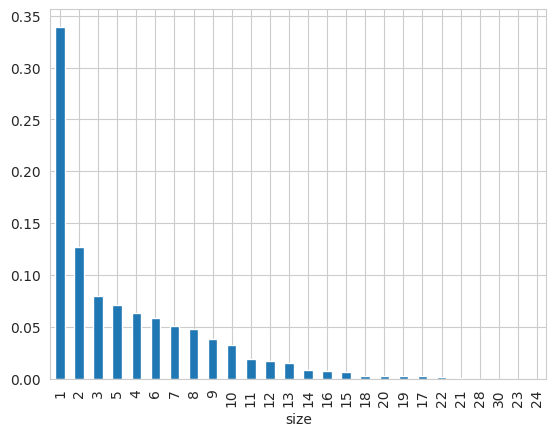

In [6]:
df.filter(pl.col("queue").eq(0))["size"].to_pandas().value_counts(normalize=True).plot(kind="bar")

<Axes: xlabel='size'>

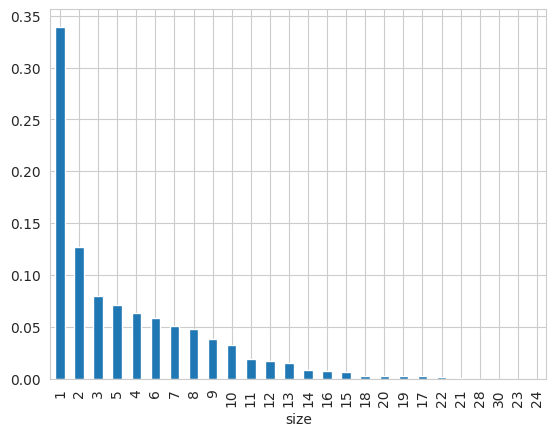

In [6]:
df.filter(pl.col("queue").eq(0))["size"].to_pandas().value_counts(normalize=True).plot(kind="bar")

In [7]:
df

date,ts_event,event,size,price,side,spread,imbalance,queue,q_4,q_3,q_2,q_1,q_-1,q_-2,q_-3,q_-4,total_best,delta_t
date,"datetime[ns, US/Eastern]",str,i64,i32,i64,i32,f64,i32,i64,i64,i64,i64,i64,i64,i64,i64,i32,i64
2023-12-14,2023-12-14 10:00:00.043812014 EST,"""Cancel""",1,2684,1,1,0.6,1,26,7,4,1,4,5,8,10,0,null
2023-12-14,2023-12-14 10:00:00.047958755 EST,"""Add""",1,2684,1,1,0.6,1,26,7,4,1,4,5,8,10,0,4146741
2023-12-14,2023-12-14 10:00:00.052019457 EST,"""Cancel""",2,2682,-1,1,0.6,-2,26,7,4,1,4,5,8,10,0,4060702
2023-12-14,2023-12-14 10:00:00.062527860 EST,"""Add""",2,2682,-1,1,0.6,-2,26,7,4,1,4,3,8,10,0,10508403
2023-12-14,2023-12-14 10:00:00.079288897 EST,"""Cancel""",1,2684,1,1,0.6,1,26,7,4,1,4,5,8,10,0,16761037
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2023-12-14,2023-12-14 15:29:58.097749612 EST,"""Add""",2,2603,-1,1,-0.6,-1,42,41,26,34,9,37,85,883,3,302950795
2023-12-14,2023-12-14 15:29:58.719752071 EST,"""Cancel""",2,2603,-1,1,-0.6,-1,42,41,26,34,11,37,85,883,3,622002459
2023-12-14,2023-12-14 15:29:59.016399433 EST,"""Add""",2,2603,-1,1,-0.6,-1,42,41,26,34,9,37,85,883,3,296647362


In [9]:
df.group_by("imbalance", "spread").agg(pl.col("delta_t").flatten())

imbalance,spread,delta_t
f64,i32,list[i64]
-0.6,1,"[35863, 349283, … 1414]"
-0.9,1,"[557038730, 119845088, … 580699935]"
0.6,2,"[2365, 7681, … 1602]"
-0.6,2,"[1940632, 1647, … 240922]"
-0.5,1,"[359990833, 1302559030, … 435099190]"
…,…,…
-0.1,2,"[109773, 7191, … 22039]"
-0.3,2,"[25506377, 2392, … 10697]"
0.1,1,"[341533, 285067, … 20760]"


In [3]:
stats = df.group_by("imbalance", "spread", "total_best", "queue", "side", "event").agg(
    pl.col("len").sum(), pl.col("delta_t_sum").sum()
)

In [4]:
stats = stats.with_columns(
    total_len_cat=pl.col("len").sum().over("imbalance", "spread", "total_best")
)

In [5]:
probabilities_3d = stats.select(
    "imbalance",
    "spread",
    "total_best",
    "queue",
    "side",
    "event",
    probability=pl.col("len").truediv(pl.col("total_len_cat")),
).sort("imbalance", "spread", "total_best", "queue", "side", "event")

In [6]:
imbalances = probabilities_3d["imbalance"].unique()
total_bests = probabilities_3d["total_best"].unique()

spread1_combos = (
    pl.DataFrame({"imbalance": imbalances})
    .join(pl.DataFrame({"total_best": total_bests}), how="cross")
    .join(pl.DataFrame({"event": ["Add", "Cancel", "Trade"]}), how="cross")
    .join(pl.DataFrame({"queue": [-2, -1, 1, 2]}), how="cross")
    .with_columns(
        spread=pl.lit(1),
        side=pl.when(pl.col("queue") > 0).then(1).otherwise(-1),
    )
).with_columns(pl.col("queue").cast(pl.Int32))

spread2_combos = (
    pl.DataFrame({"imbalance": imbalances})
    .join(pl.DataFrame({"total_best": total_bests}), how="cross")
    .join(
        pl.DataFrame(
            {
                "event": ["Create_Ask", "Create_Bid"],
                "side": [1, -1],
            }
        ),
        how="cross",
    )
    .with_columns(
        spread=pl.lit(2),
        queue=pl.lit(0),
    )
).select(
    "imbalance", "total_best", "event", "queue", "spread", pl.col("side").cast(pl.Int32)
)

valid_combos = pl.concat([spread1_combos, spread2_combos])